## **Program to perform 4D-Var data assimilation on the Lorenz equations**
### (c) 2002  Data Assimilation Research Centre
### Original Fortran program by Marek Wlasak Converted to Matlab by Amos Lawless

# **Instala o Octave e o plugin para jupyter notebook**

In [ ]:
!apt install octave

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
octave is already the newest version (6.4.0-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [ ]:
!pip install oct2py

In [ ]:
%load_ext oct2py.ipython

# **MAIN PROGRAM**



## **Program's brief description**

In [ ]:
%%octave

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Program to perform 4D-Var data assimilation on the
% Lorenz equations
%
%
%  (c) 2002  Data Assimilation Research Centre
%
%  Original Fortran program by Marek Wlasak
%  Converted to Matlab by Amos Lawless
%
%  Change history:
%      Changes to make code more robust and add further options
%                       (Amos Lawless)
%      16/03/04  Corrections to code
%                Remove high memory allocations
%                Ensure windows appear in correct place
%                       (Amos Lawless)
%
%  List of main variables
%    a:          sigma coefficient in equations
%    r:          rho coefficient in equations
%    b:          beta coefficient in equations
%
%    ta:         Length of assimilation window
%    tf:         Length of forecast window
%    h:          Time step for numerical scheme
%    freq:       Frequency of observations in time steps
%    tstep:      Number of time steps for assimilation
%    fcstep:     Total number of time steps for assimilation + forecast
%
%    [xx,yy,zz]: Truth values of trajectory
%    [xf,yf,zf]: First guess values of trajectory
%    [x,y,z]:    Calculated values of trajectory and final analysis
%    [lx,ly,lz]: Gradient values calculated from adjoint
%
%    [datx,daty,datz]: Observation values
%    D:                Observation weighting matrix
%    max_iterations:   Maximum number of minimization iterations
%    tolerance:        Convergence tolerance for minimization
%    s:                Calculated step length in minimization
%
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


## **1. Set up**

In [ ]:
%%octave

% Determine screen size and set up figure positions
ss=get(0,'ScreenSize');
fig_width=0.55*ss(3);
fig_height=0.4*ss(4);
pos_1=[0.02*ss(3),0.55*ss(4),fig_width,fig_height];
pos_2=[0.02*ss(3),0.05*ss(4),fig_width,fig_height];
pos_3=[0.6*ss(3),0.45*ss(4),0.4*ss(3),0.45*ss(4)];
pl=0.6*ss(3);
pb=0.05*ss(4);
pw=0.3*ss(3);
ph=0.3*ss(4);
pos_4=[pl,pb,pw,ph];
pos_5=[0.02*pw,0.8*ph,0.95*pw,0.2*ph];
pos_6=[0.02*pw,0.02*ph,0.95*pw,0.75*ph];
%
format long
%parameters
a=1.0d1;       % sigma
b=8.0d0/3.0d0; % rho
r=2.8d1;       % beta

## **2. Input truth parameters and calculate truth**

### function **modeuler**

In [ ]:
%%octave

function [xo,yo,zo]=modeuler(tstep,h,j,zval,yval,xval,a,r,b)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
%  Purpose: Apply modified Euler scheme to the  Lorenz equations
%
%  (c) 2002  Data Assimilation Research Centre
%
%  Original Fortran program by Marek Wlasak
%  Converted to Matlab by Amos Lawless
%
%  List of main variables
%    a:          sigma coefficient in equations
%    r:          rho coefficient in equations
%    b:          beta coefficient in equations
%    h:          Time step for numerical scheme
%    tstep:      Number of time steps to perform
%    [xval,yval,zval]: Initial fields
%    j:          Index to pick up correct initial field
%
%  Output:
%    [xo,yo,zo]: Trajectories of evolved fields
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
x=zeros(tstep,1);
y=zeros(tstep,1);
z=zeros(tstep,1);
%
x(1)=xval(j+1);
y(1)=yval(j+1);
z(1)=zval(j+1);
%
for i = 1:tstep
  kx1=h*f(a,x(i),y(i),z(i));
  ky1=h*g(r,x(i),y(i),z(i));
  kz1=h*fg(b,x(i),y(i),z(i));

  kx2=h*f(a,x(i)+kx1,y(i)+ky1,z(i)+kz1);
  ky2=h*g(r,x(i)+kx1,y(i)+ky1,z(i)+kz1);
  kz2=h*fg(b,x(i)+kx1,y(i)+ky1,z(i)+kz1);

  x(i+1)=x(i)+0.5d0*(kx1+kx2);
  y(i+1)=y(i)+0.5d0*(ky1+ky2);
  z(i+1)=z(i)+0.5d0*(kz1+kz2);
end

xo=x;
yo=y;
zo=z;
%
function [f_out]=f(a,xvl,yvl,zvl);
      f_out=a*(yvl-xvl);

function [g_out]=g(r,xvl,yvl,zvl);
      g_out=r*xvl-yvl-xvl*zvl;

function [fg_out]=fg(b,xvl,yvl,zvl);
      fg_out=xvl*yvl-b*zvl;


### initial contidions

In [ ]:
%%octave

%---------------------------------------------------------------------
%  2. Input truth parameters and calculate truth
%---------------------------------------------------------------------
% Inputs 1
% True value of x at t=0
truex=1.0;

% True value of y at t=0
truey=1.0;

% True value of z at t=0
truez=1.0;


### parameters

In [ ]:
%%octave

% Inputs 2
% Length of assimilation window
ta=3;

% Length of subsequent forecast
tf=3;

ystr='Time step';
h=0.05;

% Frequency of observations (in time steps)
freq=2;

tstep = ta/h+1; %41
fcstep = (ta+tf)/h; %100

% Run truth
guessx(1)=truex;
guessy(1)=truey;
guessz(1)=truez;
j=0;
[xx,yy,zz]=modeuler(fcstep,h,j,guessz,guessy,guessx,a,r,b);

## **3. Calculate observations and plot truth and observations**


In [ ]:
%%octave

%---------------------------------------------------------------------
% 3. Calculate observations and plot truth and observations
%---------------------------------------------------------------------
D=zeros(tstep,1);
n_obs = (tstep-1) / freq + 1;
datx=zeros(n_obs,1);
daty=zeros(n_obs,1);
datz=zeros(n_obs,1);
%l_noise=menu_asl('Noise on observations?','No','Yes');
l_noise=2;
l_noise=l_noise-1;
if l_noise==1
  sc_x_noise=randn(n_obs,1);
  sc_y_noise=randn(n_obs,1);
  sc_z_noise=randn(n_obs,1);
  %sd_str=inputdlg('Variance of observation error');
  %sd=str2num(sd_str{1});
  sd=0.1;
  var=sqrt(sd);
  RX=var*sc_x_noise;
  RY=var*sc_y_noise;
  RZ=var*sc_z_noise;
else
  for i=1:n_obs;
    RX(i)=0.0;
    RY(i)=0.0;
    RZ(i)=0.0;
  end
end
% Set up data and matrix D
j=1;
for i=1:freq:tstep
  datx(i)=xx(i)+RX(j);
  daty(i)=yy(i)+RY(j);
  datz(i)=zz(i)+RZ(j);
  D(i) = 1.;
  j=j+1;
end



ans = -16.00357857486066

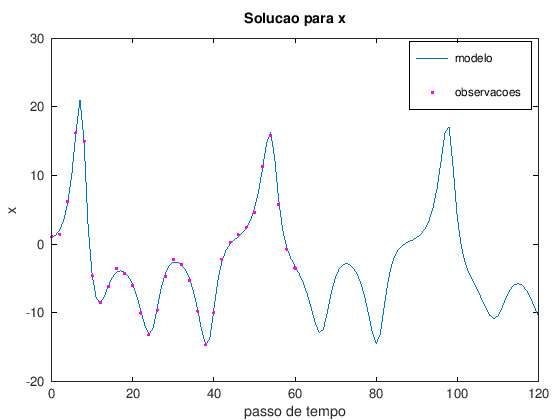

In [ ]:
%%octave

% Plot truth and observations
xvals=0:fcstep;
vec=1:freq:tstep;
v=vec-1;
for i=vec
  x_ob(i)=datx(i);
  z_ob(i)=datz(i);
end
% x_ob and z_ob are temporary arrays for plotting
%
h1=figure(1);
%clf;
plot(xvals,xx)
hold on
plot(v,x_ob(vec),'.m')
%hold on
xlabel('passo de tempo')
ylabel('x')
title('Solucao para x')
legend('modelo','observacoes')
%



ans = -16.72425198800664

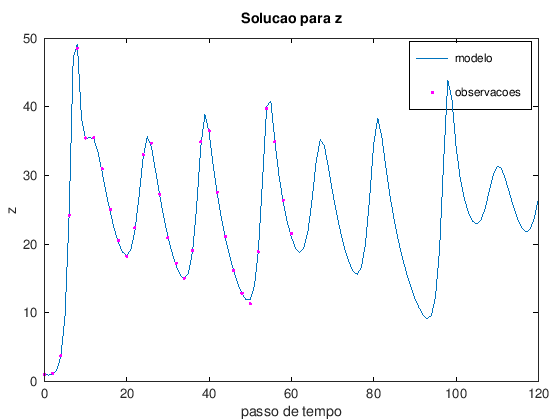

In [ ]:
%%octave

h2=figure(2);
plot(xvals,zz)
hold on
plot(v,z_ob(vec),'.m')
hold on
xlabel('passo de tempo')
ylabel('z')
title('Solucao para z')
legend('modelo','observacoes')

## **4. Input initial guess and run model from this**

### Choose number of time steps between observations

ans = -15.49607442016896

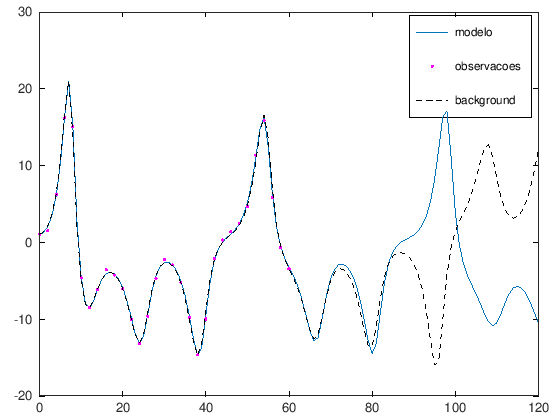

In [ ]:
%%octave

xstr='Initial guess of x at t=0';
ystr='Initial guess of y at t=0';
zstr='Initial guess of z at t=0';
% guess_str=inputdlg({xstr,ystr,zstr},'Initial guess');
guessx(2)=1.05;
guessy(2)=1.05;
guessz(2)=1.05;
%
j=1;
% Plot first guess
[xf,yf,zf]=modeuler(fcstep,h,j,guessz,guessy,guessx,a,r,b);
h3=figure(3);
plot(xvals,xx)
hold on
plot(v,x_ob(vec),'.m')
plot(xvals,xf,'--k')
legend('modelo','observacoes','background')



ans = -15.62566531932649

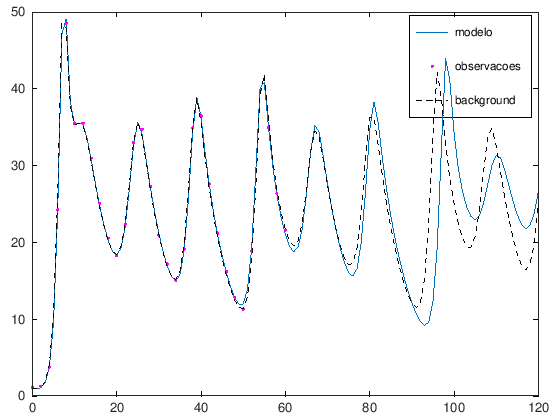

In [ ]:
%%octave
h4=figure(4);
plot(xvals,zz)
hold on
plot(v,z_ob(vec),'.m')
plot(xvals,zf,'--k')
legend('modelo','observacoes','background')
hold on

## **5. Input minimization info and perform minimization**

### function **calcfg_inc**

In [ ]:
%%octave

function [f,g] = calcfg_inc(tstep,h,x,y,z,x_d,y_d,z_d,x0_p,y0_p,z0_p,...
                            a,r,b,D,freq)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
%  Purpose: Calculate cost function and its gradient
%
%
%  (c) 2002  Data Assimilation Research Centre
%
%  Written by Amos Lawless
%
%  List of main variables
%    a:          sigma coefficient in equations
%    r:          rho coefficient in equations
%    b:          beta coefficient in equations
%    D:          Observation weighting matrix
%    h:          Time step for numerical scheme
%    freq:       Frequency of observations
%    tstep:      Number of time steps to perform
%    [x,y,z]:    Forward trajectory
%    [x_d,y_d,z_d]: Innovations
%    [x0_p,y0_p,z0_p]: Initial perturbations
%
%  Output:
%    [f,g]: Cost function and gradient
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

f=0.0;
x_p=zeros(tstep,1); % Perturbations
y_p=zeros(tstep,1); % Perturbations
z_p=zeros(tstep,1); % Perturbations
%
x_p(1)=x0_p;
y_p(1)=y0_p;
z_p(1)=z0_p;
%
% Calculo da funcao custo
[x_p,y_p,z_p]=modeuler_tl(tstep,h,0,z,y,x,z_p,y_p,x_p,a,r,b);
%
     for i=1:freq:tstep
         f = f + 0.5*((x_d(i)+x_p(i))*(x_d(i)+x_p(i))*D(i) ...
                      + (y_d(i)+y_p(i))*(y_d(i)+y_p(i))*D(i) ...
                      + (z_d(i)+z_p(i))*(z_d(i)+z_p(i))*D(i));
     end

%       for i=1:freq:tstep
%           f = f + 0.5*((x_p(i)-x_d(i))'*D*(x_p(i)-x_d(i)) ...
%                      - (y_p(i)-y_d(i))'*D*(y_p(i)-x_d(i)) ...
%                      - (z_p(i)-z_d(i))'*D*(z_p(i)-x_d(i)));
%       end

%

% calculo do gradiente da funcao custo
x_hat=zeros(tstep,1);
y_hat=zeros(tstep,1);
z_hat=zeros(tstep,1);
%
x_hat(tstep) = (x_d(tstep)+x_p(tstep))*D(tstep);
y_hat(tstep) = (y_d(tstep)+y_p(tstep))*D(tstep);
z_hat(tstep) = (z_d(tstep)+z_p(tstep))*D(tstep);
%
for i=tstep-1:-1:1
    [x1_hat,y1_hat,z1_hat] = modeuler_adj(1,h,0,z(i),y(i),x(i),...
               x_hat(i+1),y_hat(i+1),z_hat(i+1),a,r,b);

    x_hat(i) = x1_hat(1) + (x_d(i)+x_p(i))*D(i);
    y_hat(i) = y1_hat(1) + (y_d(i)+y_p(i))*D(i);
    z_hat(i) = z1_hat(1) + (z_d(i)+z_p(i))*D(i);
end
g=[x_hat(1),y_hat(1),z_hat(1)];


### function **modeuler_tl**

In [ ]:
%%octave

function [xo_p,yo_p,zo_p]=modeuler_tl(tstep,h,j,z,y,x,...
   zval_p,yval_p,xval_p,a,r,b)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
%  Purpose: Tangent linear code of modeuler.m
%
%  (c) 2004  Data Assimilation Research Centre
%
%  Written  by Amos Lawless
%
%  List of main variables
%    a:          sigma coefficient in equations
%    r:          rho coefficient in equations
%    b:          beta coefficient in equations
%    h:          Time step for numerical scheme
%    tstep:      Number of time steps to perform
%    [xval,yval,zval]: Linearization state fields at all times
%    [xval_p,yval_p,zval_p]: Initial perturbations
%    j:          Index to pick up correct initial field
%
%  Output:
%    [xo_p,yo_p,zo_p]: Evolved perturbations
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
x_p=zeros(tstep,1);
y_p=zeros(tstep,1);
z_p=zeros(tstep,1);
%
x_p(1)=xval_p(j+1);
y_p(1)=yval_p(j+1);
z_p(1)=zval_p(j+1);
%
for i = 1:tstep
  kx1 = h*a*(y(i)-x(i));
  ky1 = h*(r*x(i)-y(i)-x(i)*z(i));
  kz1 = h*(x(i)*y(i) - b*z(i));
%
  kx1_p = h*a*(y_p(i)-x_p(i));
  ky1_p = h*(r*x_p(i)-y_p(i)-x_p(i)*z(i)-x(i)*z_p(i));
  kz1_p = h*(x_p(i)*y(i)+x(i)*y_p(i)-b*z_p(i));

  kx2_p = h*a*(y_p(i)+ky1_p-x_p(i)-kx1_p);
  ky2_p = h*(r*(x_p(i)+kx1_p)-y_p(i)-ky1_p ...
          - (x_p(i)+kx1_p)*(z(i)+kz1) - (x(i)+kx1)*(z_p(i)+kz1_p));
  kz2_p = h*((x_p(i)+kx1_p)*(y(i)+ky1)+(x(i)+kx1)*(y_p(i)+ky1_p) ...
          - b*(z_p(i)+kz1_p));
%
  x_p(i+1)=x_p(i)+0.5d0*(kx1_p+kx2_p);
  y_p(i+1)=y_p(i)+0.5d0*(ky1_p+ky2_p);
  z_p(i+1)=z_p(i)+0.5d0*(kz1_p+kz2_p);
end

xo_p=x_p;
yo_p=y_p;
zo_p=z_p;
%

### function **modeuler_adj**


In [ ]:
%%octave

function [xval_hat,yval_hat,zval_hat]=modeuler_adj(tstep,h,j,z,y,x,...
   xo_hat,yo_hat,zo_hat,a,r,b)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
%  Purpose: Adjoint code of modeuler.m
%
%  (c) 2004  Data Assimilation Research Centre
%
%  Written  by Amos Lawless
%
%  List of main variables
%    a:          sigma coefficient in equations
%    r:          rho coefficient in equations
%    b:          beta coefficient in equations
%    h:          Time step for numerical scheme
%    tstep:      Number of time steps to perform
%    [xval,yval,zval]: Linearization state fields at all times
%    [xo_hat,yo_hat,zo_hat]: Input adjoint variables
%    j:          Index to pick up correct initial field
%
%  Output:
%    [xval_hat,yval_hat,zval_hat]: Output adjoint variables
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
x_hat=zeros(tstep+1,1);
y_hat=zeros(tstep+1,1);
z_hat=zeros(tstep+1,1);

xval_hat=zeros(tstep+1,1);
yval_hat=zeros(tstep+1,1);
zval_hat=zeros(tstep+1,1);

x_hat(tstep+1) = x_hat(tstep+1) + xo_hat;
y_hat(tstep+1) = y_hat(tstep+1) + yo_hat;
z_hat(tstep+1) = z_hat(tstep+1) + zo_hat;
xo_hat = 0.0d0;
yo_hat = 0.0d0;
zo_hat = 0.0d0;

for i=tstep:-1:1
  kx1 = h*a*(y(i)-x(i));
  ky1 = h*(r*x(i)-y(i)-x(i)*z(i));
  kz1 = h*(x(i)*y(i) - b*z(i));
%
  kz1_hat = 0.5 * z_hat(i+1);
  kz2_hat = 0.5 * z_hat(i+1);
  z_hat(i) = z_hat(i) + z_hat(i+1);
  z_hat(i+1) = 0;
  ky1_hat = 0.5 * y_hat(i+1);
  ky2_hat = 0.5 * y_hat(i+1);
  y_hat(i) = y_hat(i) + y_hat(i+1);
  y_hat(i+1) = 0;
  kx1_hat = 0.5 * x_hat(i+1);
  kx2_hat = 0.5 * x_hat(i+1);
  x_hat(i) = x_hat(i) + x_hat(i+1);
  x_hat(i+1) = 0;
%
  x_hat(i) = x_hat(i) + h*kz2_hat*(y(i)+ky1);
  kx1_hat = kx1_hat + h*kz2_hat*(y(i)+ky1);
  y_hat(i) = y_hat(i) + h*(x(i)+kx1)*kz2_hat;
  ky1_hat = ky1_hat + h*(x(i)+kx1)*kz2_hat;
  z_hat(i) = z_hat(i) - h*b*kz2_hat;
  kz1_hat = kz1_hat - h*b*kz2_hat;
  kz2_hat = 0.0d0;
%
  x_hat(i) = x_hat(i) + h*r*ky2_hat;
  kx1_hat = kx1_hat + h*r*ky2_hat;
  y_hat(i) = y_hat(i) - h* ky2_hat;
  ky1_hat = ky1_hat - h*ky2_hat;
  x_hat(i) = x_hat(i) - h*ky2_hat*(z(i)+kz1);
  kx1_hat = kx1_hat - h*ky2_hat*(z(i)+kz1);
  z_hat(i) = z_hat(i) - h*(x(i)+kx1)*ky2_hat;
  kz1_hat = kz1_hat - h*(x(i)+kx1)*ky2_hat;
  ky2_hat = 0.0d0;
%
  y_hat(i) = y_hat(i) + h*a*kx2_hat;
  ky1_hat = ky1_hat + h*a*kx2_hat;
  x_hat(i) = x_hat(i) - h*a*kx2_hat;
  kx1_hat = kx1_hat - h*a*kx2_hat;
  kx2_hat = 0.0d0;
%
  x_hat(i) = x_hat(i) + h*kz1_hat*y(i);
  y_hat(i) = y_hat(i) + h*x(i)*kz1_hat;
  z_hat(i) = z_hat(i) - h*b*kz1_hat;
  kz1_hat = 0.0d0;
  x_hat(i) = x_hat(i) + h*r*ky1_hat;
  y_hat(i) = y_hat(i) - h*ky1_hat;
  x_hat(i) = x_hat(i) - h*ky1_hat*z(i);
  z_hat(i) = z_hat(i) - h*x(i)*ky1_hat;
  ky1_hat = 0.0d0;
  y_hat(i) = y_hat(i) + h*a*kx1_hat;
  x_hat(i) = x_hat(i) - h*a*kx1_hat;
  kx1_hat = 0.0d0;
end
xval_hat(j+1) = xval_hat(j+1) + x_hat(1);
x_hat(1) = 0.0d0;
yval_hat(j+1) = yval_hat(j+1) + y_hat(1);
y_hat(1) = 0.0d0;
zval_hat(j+1) = zval_hat(j+1) + z_hat(1);
z_hat(1) = 0.0d0;


### Input minimization info and perform minimization

In [ ]:
%%octave

%---------------------------------------------------------------------
% 5. Input minimization info and perform minimization
%---------------------------------------------------------------------
% Maximum number of iterations
max_iterations=30;

% Tolerance
tolerance=1d-2;

% Outer loops
outer_loops=2;

%zstr={'30','1d-2','2'};
%min_str=inputdlg({xstr,ystr,y2str},'Minimization control',1,zstr);
%
k=1;
costplot=zeros(1);
normplot=zeros(1);
for i_outer=1:outer_loops
%%%% Start of outer loop %%%%
disp(['Outer loop ' num2str(i_outer)])
  [x,y,z]=modeuler(tstep,h,i_outer,guessz,guessy,guessx,a,r,b);
  x0_p(1:2) = 0.0d0;
  y0_p(1:2) = 0.0d0;
  z0_p(1:2) = 0.0d0;
% Calculate innovations
  for i=1:freq:tstep
    x_d(i) = x(i) - datx(i);
    y_d(i) = y(i) - daty(i);
    z_d(i) = z(i) - datz(i);
  end

j=2;
  [f,g] = calcfg_inc(tstep,h,x,y,z,x_d,y_d,z_d,...
                     x0_p(j),y0_p(j),z0_p(j),a,r,b,D,freq);
  cost(j)=f;
  lx=g(1);
  ly=g(2);
  lz=g(3);


lnorm(j)=sqrt(lx(1)*lx(1)+ly(1)*ly(1)+lz(1)*lz(1));
%     minimisation via least squares
l_converged=0;
if lnorm(j)<tolerance
  l_converged=1;
end

%%% Inner minimization
while lnorm(j)>tolerance & l_converged==0  % 70
  s(j)=0.5d0;
% normalise gradient vector
  gx=lx(1)/lnorm(j);
  gy=ly(1)/lnorm(j);
  gz=lz(1)/lnorm(j);

  x0_p(j+1) = x0_p(j)-s(j)*gx;
  y0_p(j+1) = y0_p(j)-s(j)*gy;
  z0_p(j+1) = z0_p(j)-s(j)*gz;
  [f,g] = calcfg_inc(tstep,h,x,y,z,x_d,y_d,z_d,...
                     x0_p(j+1),y0_p(j+1),z0_p(j+1),a,r,b,D,freq);
  cost(j+1)=f;
  lx=g(1);
  ly=g(2);
  lz=g(3);

  lnorm(j+1)=sqrt(lx(1)*lx(1)+ly(1)*ly(1)+lz(1)*lz(1));

  if (j-1>max_iterations)  % Max number of iterations reached
    l_converged=1;
    disp('Failed to converge in maximum number of iterations')
    j=j-1;
  else
    Iteration=j-1
    while (lnorm(j+1) >= lnorm(j) & s(j) > tolerance ...
                       & l_converged == 0) % 75
      s(j)=s(j)*0.5d0;
      x0_p(j+1) = x0_p(j)-s(j)*gx;
      y0_p(j+1) = y0_p(j)-s(j)*gy;
      z0_p(j+1) = z0_p(j)-s(j)*gz;

      [f,g] = calcfg_inc(tstep,h,x,y,z,x_d,y_d,z_d,...
                     x0_p(j+1),y0_p(j+1),z0_p(j+1),a,r,b,D,freq);
      cost(j+1)=f;
      lx=g(1);
      ly=g(2);
      lz=g(3);
      lnorm(j+1)=sqrt(lx(1)*lx(1)+ly(1)*ly(1)+lz(1)*lz(1));
% Convergence test on norm of gradient
      if (abs((lnorm(j+1)-lnorm(j)))<tolerance)
        disp('Converged on change in gradient')
        number_of_iterations=j-1
        l_converged=1;
      end
    end
      if (~l_converged)
        j=j+1;
      end
  end
end  % Inner minimization

guessx(i_outer+2) = guessx(i_outer+1) + x0_p(j+1);
guessy(i_outer+2) = guessy(i_outer+1) + y0_p(j+1);
guessz(i_outer+2) = guessz(i_outer+1) + z0_p(j+1);

costplot(k:k+j-1) = cost(2:j+1);
normplot(k:k+j-1) = lnorm(2:j+1);
k=k+j;

end  % i_outer
Norm_of_gradient=lnorm(j+1)


Outer loop 1

Iteration = 1

Iteration = 2

Iteration = 3

Iteration = 4

Iteration = 5

Iteration = 6

Iteration = 7

Iteration = 8

Iteration = 9

Iteration = 10

Iteration = 11

Iteration = 12

Iteration = 13

Iteration = 14

Iteration = 15

Iteration = 16

Iteration = 17

Iteration = 18

Iteration = 19

Iteration = 20

Iteration = 21

Iteration = 22

Iteration = 23

Iteration = 24

Iteration = 25

Iteration = 26

Iteration = 27

Iteration = 28

Iteration = 29

Iteration = 30

Failed to converge in maximum number of iterations

Outer loop 2

Iteration = 1

Iteration = 2

Iteration = 3

Iteration = 4

Iteration = 5

Iteration = 6

Iteration = 7

Iteration = 8

Iteration = 9

Iteration = 10

Iteration = 11

Iteration = 12

Iteration = 13

Iteration = 14

Iteration = 15

Iteration = 16

Iteration = 17

Iteration = 18

Iteration = 19

Iteration = 20

Iteration = 21

Iteration = 22

Iteration = 23

Iteration = 24

Iteration = 25

Iteration = 26

Iteration = 27

Iteration = 28

Iteration = 29

Iteration = 30

Failed to converge in maximum number of iterations

Norm_of_gradient = 72.08057901586355

## **6. Run forecast from final analysis and plot**


ans = -14.00540854874746

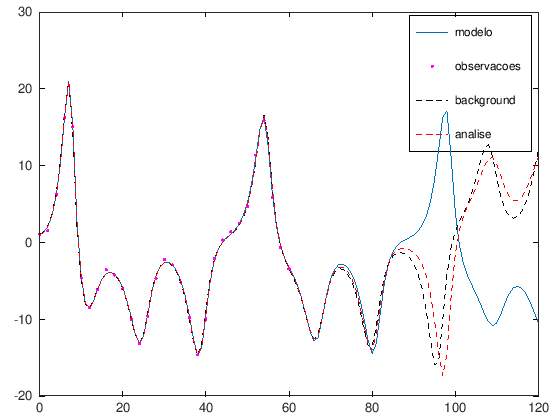

In [ ]:
%%octave

%---------------------------------------------------------------------
% 6. Run forecast from final analysis and plot
%---------------------------------------------------------------------
jtemp=0;
guessx(1)=x(1);
guessy(1)=y(1);
guessz(1)=z(1);
[x,y,z]=modeuler(fcstep,h,jtemp,guessz,guessy,guessx,a,r,b);

%h5=figure(5)
plot(xvals,xx)
hold on
plot(v,x_ob(vec),'.m')
plot(xvals,xf,'--k')
plot(xvals,x,'--r')
legend('modelo','observacoes','background','analise')

% Plot vertical line at start of forecast
yminmax=get(gca,'YLim');
yspace=(yminmax(2)-yminmax(1))*0.01;
yvals=yminmax(1):yspace:yminmax(2);
%line(tstep-1,yvals,'LineStyle',':','Color','k')
hold off
%



ans = -14.44256023529798

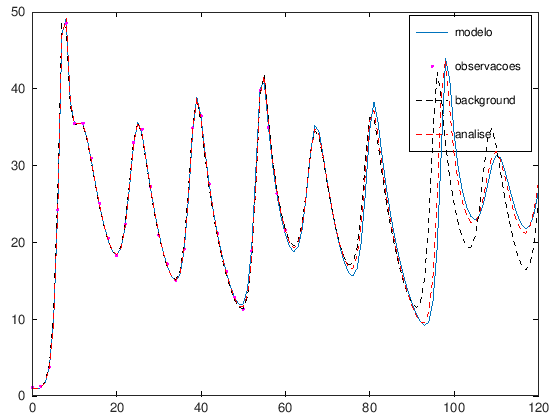

In [ ]:
%%octave
plot(xvals,zz)
hold on
plot(v,z_ob(vec),'.m')
plot(xvals,zf,'--k')
plot(xvals,z,'--r')
legend('modelo','observacoes','background','analise')
hold on
% Plot vertical line at start of forecast
yminmax=get(gca,'YLim');
yspace=(yminmax(2)-yminmax(1))*0.01;
yvals=yminmax(1):yspace:yminmax(2);
%line(tstep-1,yvals,'LineStyle',':','Color','k')
hold off

## **7. Calculate and plot error**

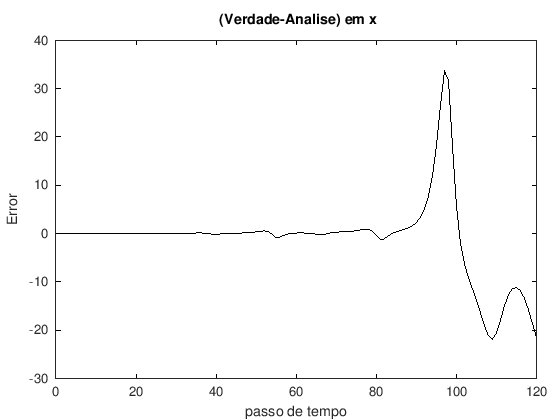

In [ ]:
%%octave

%---------------------------------------------------------------------
%  7. Calculate and plot error
%---------------------------------------------------------------------
x_error=xx-x;

plot(xvals,x_error,'k-');
xlabel('passo de tempo');ylabel('Error')
title(' (Verdade-Analise) em x')

% Plot vertical line at start of forecast
yminmax=get(gca,'YLim');
yspace=(yminmax(2)-yminmax(1))*0.01;
yvals=yminmax(1):yspace:yminmax(2);
%line(tstep-1,yvals,'LineStyle',':','Color','k')
%



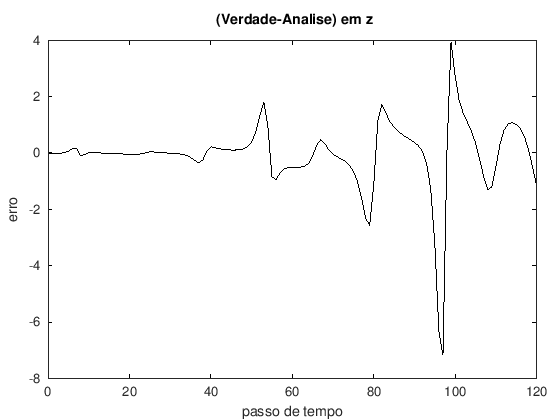

In [ ]:
%%octave
z_error=zz-z;

plot(xvals,z_error,'k-')
xlabel('passo de tempo');ylabel('erro')
title(' (Verdade-Analise) em z')
% Plot vertical line at start of forecast
yminmax=get(gca,'YLim');
yspace=(yminmax(2)-yminmax(1))*0.01;
yvals=yminmax(1):yspace:yminmax(2);
%line(tstep-1,yvals,'LineStyle',':','Color','k')

## **8. Plot convergence**

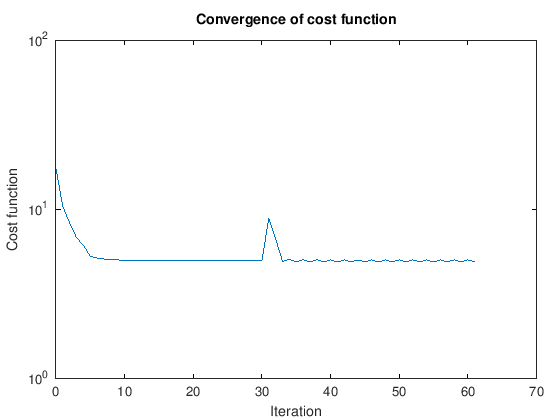

In [ ]:
%%octave

%-----------------------------------------------------------------------
%  8. Plot convergence
%---------------------------------------------------------------------
xmax=max(size(normplot));
xvals=0:xmax-1;

semilogy(xvals,costplot)
title('Convergence of cost function')
xlabel('Iteration')
ylabel('Cost function')



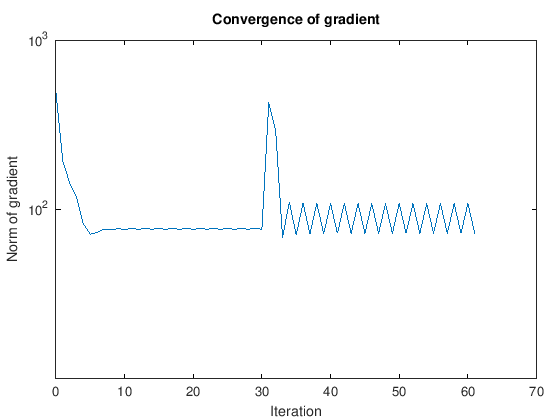

In [ ]:
%%octave

semilogy(xvals,normplot)
title('Convergence of gradient')
xlabel('Iteration')
ylabel('Norm of gradient')

### **9. Write out options chosen**

In [ ]:
%%octave

%-----------------------------------------------------------------------
% 9. Write out options chosen
%---------------------------------------------------------------------
text1={'List of options chosen'};
text2={['True (x,y,z) at t=0:   (' num2str(truex) ',' num2str(truey) ',' ...
 num2str(truez)  ')']};
text3={['First guess (x,y,z) at t=0:   (' num2str(guessx(1)) ',' num2str(guessy(1)) ',' ...
 num2str(guessz(1))  ')']};
text4={['Length of assimilation window: ' num2str(ta)]};
text5={['Length of subsequent forecast: ' num2str(tf)]};
text6={['Time step: ' num2str(h)]};
text7={['Frequency of observations = ' num2str(freq)]};
%text9={['Maximum iterations: ' min_str{1}]};
%text10={['Tolerance: ' min_str{2}]};
if l_noise==0
  text11={['No noise on observations']};
else
  text11={['Observations have random noise with variance ' num2str(sd)]};
end

str1=[text2;text3;text4;text5;text6;text7;text11];
disp(str1)

{

  [1,1] = True (x,y,z) at t=0:   (1,1,1)

  [2,1] = First guess (x,y,z) at t=0:   (0.99027,1.0046,1.0226)

  [3,1] = Length of assimilation window: 3

  [4,1] = Length of subsequent forecast: 3

  [5,1] = Time step: 0.05

  [6,1] = Frequency of observations = 2

  [7,1] = Observations have random noise with variance 0.1

}